# Build Graph using TF-IDF

## imports 

In [28]:
%matplotlib inline
import json

import numpy as np
import pandas as pd

import scipy.sparse as sp
from scipy.spatial.distance import cosine

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

import networkx as nx
import matplotlib.pyplot as plt

## data load

In [72]:
%%time

data_path = '../../data/summary/data/train.json'
with open(data_path, 'r', encoding='utf8') as f:
    dataset = [json.loads(line) for line in f]

Wall time: 4.49 s


In [73]:
total_len = len(dataset)

In [130]:
sample_id = np.random.randint(total_len, size=1)
sample_id = int(sample_id)
sample = dataset[sample_id]

text = sample['doc']
labels = sample['labels']
summary = sample['summaries']

In [131]:
sentences = text.split('\n')

## build graph using TF-IDF

In [132]:
tfidf = TfidfVectorizer().fit(sentences)

In [133]:
tdm = tfidf.transform(sentences).toarray()

## cosine similarity matrix

In [134]:
cosine_matrix = 1 - pairwise_distances(tdm, metric="cosine")

In [135]:
cosine_matrix[0]

array([1.        , 0.10555718, 0.09768814, 0.22310821, 1.        ,
       0.14690146, 0.13561551, 0.22249869, 0.19100212, 0.03919085,
       0.06562103, 0.26404739, 0.12421969, 0.16428764, 0.05327201,
       0.02948287, 0.06190515, 0.08340465, 0.12318753, 0.10137591,
       0.14058203, 0.03138769, 0.10591109, 0.0882643 , 0.08942159,
       0.05595502, 0.09220587, 0.07579007, 0.03643108, 0.16781383,
       0.0320665 , 0.06486681, 0.        , 0.07271714, 0.        ,
       0.05663331, 0.01623267, 0.03059156, 0.        , 0.        ,
       0.04642627, 0.04813601, 0.07037353])

## adjacency matrix using threshold

In [136]:
threshold = 0.15

adj_matrix = (cosine_matrix > threshold) * 1

In [137]:
# adj_matrix

## create Graph using Networkx

In [138]:
G = nx.from_numpy_matrix(cosine_matrix)

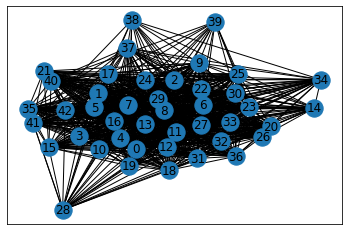

In [139]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=False)
plt.show()

## Apply GDC

### imports

In [83]:
import torch_geometric.transforms as T

from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, from_scipy_sparse_matrix
from torch_geometric.utils import to_networkx

In [140]:
# Graph to SparseMatrix
G = nx.to_scipy_sparse_matrix(G)

# sparse Matrix to Graph
edge_index, edge_attr = from_scipy_sparse_matrix(G)

In [141]:
data = Data(edge_index=edge_index, edge_attr=edge_attr)

In [151]:
gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
            normalization_out='col',
            diffusion_kwargs=dict(method='ppr', alpha=0.05),
            sparsification_kwargs=dict(method='topk', k=10,
                                           dim=0), exact=True)
data = gdc(data)

In [153]:
G = to_networkx(data, to_undirected=True)

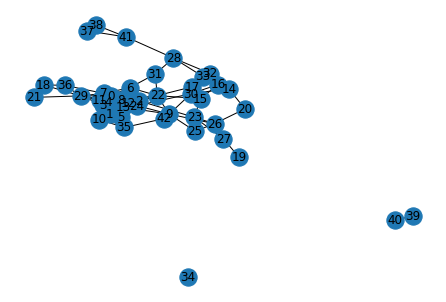

In [154]:
nx.draw(G, with_labels=True)

In [155]:
G.degree

DegreeView({0: 11, 1: 10, 2: 12, 3: 12, 4: 12, 5: 9, 6: 8, 7: 13, 8: 14, 9: 7, 10: 7, 11: 12, 12: 13, 13: 15, 14: 7, 15: 7, 16: 7, 17: 6, 18: 4, 19: 3, 20: 4, 21: 3, 22: 11, 23: 6, 24: 6, 25: 4, 26: 7, 27: 5, 28: 6, 29: 11, 30: 10, 31: 5, 32: 7, 33: 8, 34: 2, 35: 6, 36: 5, 37: 4, 38: 4, 39: 3, 40: 3, 41: 5, 42: 4})

In [156]:
label = labels.split('\n')

In [157]:
# label

In [159]:
label[29]

'1'